### 準備資料

In [256]:
import os
import numpy as np
import pandas as pd
import copy
# 特徵工程
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
# 資料視覺化
import seaborn as sns
import matplotlib.pyplot as plt
# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 設定 data_path
dir_data = './data/House Prices Advanced Regression Techniques'
f_app_train = os.path.join(dir_data, 'train.csv')
f_app_test = os.path.join(dir_data, 'test.csv')

df_train = pd.read_csv(f_app_train)
df_test = pd.read_csv(f_app_test)
df_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 特徵工程

In [257]:
# 訓練資料需要 train_X, train_Y / test_X, ids
# 在此先抽離出 train_Y 與 ids, 而
train_Y = np.log1p(df_train['SalePrice']) # [log1p] 數據平滑處理，使其更加服從高斯分佈
# 預測輸出需要 ids(識別每個預測值)
ids = df_test['Id']
# 訓練資料移除'Id'與'SalePrice'特徵欄位, axis=1(column)
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1) 
# 測試資料移除掉'Id'的特徵欄位
df_test = df_test.drop(['Id'] , axis=1)
# 將 train_X, test_X 該有的資料"合併"成 df, 先作特徵工程
df = pd.concat([df_train, df_test])    # 預設是沿著"row"合併, 若要沿著column就要加 ,axis = 1
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [258]:
# 秀出資料欄位的類型, 與對應的數量
# df.dtypes : 轉成以欄位為 index, 類別(type)為 value 的 DataFrame
# .reset_index() : 預設是將原本的 index 轉成一個新的欄位, 如果不須保留 index, 則通常會寫成 .reset_index(drop=True)
dtype_df = df.dtypes.reset_index() 
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,int64,25
1,float64,11
2,object,43


In [259]:
# 確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []

# .dtypes(欄位類型), .columns(欄位名稱) 是 DataFrame 提供的兩個方法, 這裡順便展示一下 for 與 zip 搭配的用法
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)

In [260]:
#這樣就可以單獨秀出特定類型的欄位集合, 方便做後續的特徵工程處理
print(f'{len(int_features)} Integer Features\n')
df[int_features].head()

25 Integer Features



,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,856,854,0,1710,...,0,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,1262,0,0,1262,...,1,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,920,866,0,1786,...,1,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,961,756,0,1717,...,1,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,1145,1053,0,2198,...,1,192,84,0,0,0,0,0,12,2008


In [261]:
print(f'{len(float_features)} Float Features \n')
df[float_features].head()

11 Float Features 



,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0


In [262]:
print(f'{len(object_features)} Object Features\n')
df[object_features].head()
df_object = df[object_features]

43 Object Features



### 處理缺失值 Missing value

In [263]:
# 檢查欄位缺值數量 (去掉.head()可以顯示全部)
print("欄位缺值數量")
print(df.isnull().sum().sort_values(ascending=False).head(5)) # 看十個 意思意思
print("\r\n===============================\r\n")

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print("數值型態的資料欄位數: " + f'{len(num_features)} Numeric Features\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
MMEncoder = MinMaxScaler()
# 取得訓練資料總數
train_num = train_Y.shape[0]
print("訓練資料總數: " + str(train_num))

欄位缺值數量
PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
FireplaceQu    1420
dtype: int64


數值型態的資料欄位數: 36 Numeric Features

訓練資料總數: 1460


### 特徵工程
- 補值, 做線性回歸, 並交叉驗證(Cross validation)
- 觀查標籤編碼與獨編碼熱的影響

查看地坪大小的核密度分析散布圖


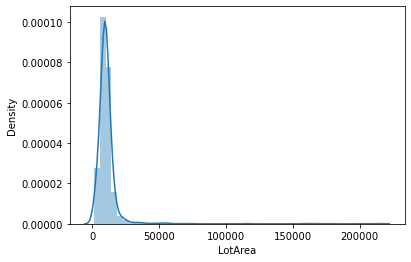


使用線性回歸計算交叉驗證的分數: 0.8466679693360535

將 LotArea 取 log1p 去除偏態後, 看散佈圖, 並重新計算分數


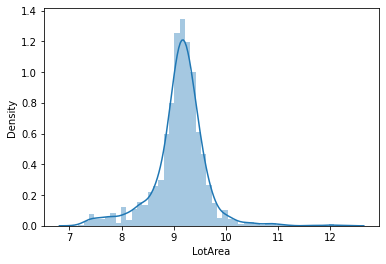


使用線性回歸計算交叉驗證的分數: 0.8528868624798054


In [264]:
# 空值補 -1
df = df.fillna(-1)
# 並建立最大最小化物件準備來去除偏態
MMEncoder = MinMaxScaler()

# 顯示 LotArea 的散佈圖 : 坪數 地坪大小
sns.distplot(df['LotArea'][:train_num])
print("查看地坪大小的核密度分析散布圖")
plt.show()

# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LinearRegression()

print("\r\n使用線性回歸計算交叉驗證的分數: "+str(cross_val_score(estimator, train_X, train_Y, cv=5).mean()))

# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = np.log1p(df_fixed['LotArea'])
sns.distplot(df_fixed['LotArea'][:train_num])
print("\r\n將 LotArea 取 log1p 去除偏態後, 看散佈圖, 並重新計算分數")
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print("\r\n使用線性回歸計算交叉驗證的分數: "+str(cross_val_score(estimator, train_X, train_Y, cv=5).mean()))

In [267]:
# 只留類別型欄位
df_object = df_object
df_object = df_object.fillna('None')
train_num = train_Y.shape[0]
df_object.head()

# 標籤編碼 + 梯度提升樹
df_temp = pd.DataFrame()
for c in df.columns:
    df_temp[c] = LabelEncoder().fit_transform(df[c])
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
print("[ 標籤編碼 + 梯度提升樹 ]")
print(f'訓練資料的shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print()

# 獨熱編碼 + 梯度提升樹
df_temp = pd.get_dummies(df)
train_X = df_temp[:train_num]
estimator = GradientBoostingRegressor()
print("[ 獨熱編碼 + 梯度提升樹 ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')
print()

# 均值編碼 + 梯度提升樹
data = pd.concat([df[:train_num], train_Y], axis=1)
for c in df.columns:
    mean_df = data.groupby([c])['SalePrice'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    data = pd.merge(data, mean_df, on=c, how='left')
    data = data.drop([c] , axis=1)
data = data.drop(['SalePrice'] , axis=1)
estimator = GradientBoostingRegressor()
print("[ 均值編碼 + 梯度提升樹 ]")
print(f'shape : {train_X.shape}')
print(f'score : {cross_val_score(estimator, data, train_Y, cv=5).mean()}')

[ 標籤編碼 + 梯度提升樹 ]
訓練資料的shape : (1460, 79)
score : 0.8991678214525451

[ 獨熱編碼 + 梯度提升樹 ]
shape : (1460, 310)
score : 0.9017486548028752

[ 均值編碼 + 梯度提升樹 ]
shape : (1460, 310)
score : 0.9530813261327788


### 特徵篩選

In [266]:
# 先合併特徵
df = pd.concat([df_object, df], axis=1)
df

# # 計算df整體相關係數, 並繪製成熱圖
# corr = df.corr()
# sns.heatmap(corr)

# print("顯示整體相關係數圖, 以利之後特徵篩選")
# plt.show()

# train_Y = np.log1p(df['SalePrice'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,548.0,0,61,0,0,0,0,0,2,2008
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,460.0,298,0,0,0,0,0,0,5,2007
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,608.0,0,42,0,0,0,0,0,9,2008
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,642.0,0,35,272,0,0,0,0,2,2006
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,0.0,0,0,0,0,0,0,0,6,2006
1455,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,286.0,0,24,0,0,0,0,0,4,2006
1456,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,576.0,474,0,0,0,0,0,0,9,2006
1457,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,0.0,80,32,0,0,0,0,700,7,2006
